In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('..')

from typing import *
from ktools.models import XGBoostModel
from ktools.utils.reduce_dataframe_usage import reduce_dataframe_size
from sklearn.model_selection import TimeSeriesSplit, KFold
from ktools.fitting.safe_cross_validation_executor import SafeCrossValidationExecutor
# from sklearn.metrics import
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression, SGDRegressor
from ktools.modelling.model_transform_wrappers.log_model_wrapper import LogModelWrapper
from ktools.preprocessing.basic_feature_transformers import *
import torch
from ktools.model_selection.walk_forward_splits import WalkForwardSplit

In [2]:
from sklearn.linear_model import SGDRegressor

class SklearnWrapper(SGDRegressor):

    def __init__(
        self,
        loss="squared_error",
        *,
        penalty="l2",
        alpha=0.0001,
        l1_ratio=0.15,
        fit_intercept=True,
        max_iter=1000,
        tol=1e-3,
        shuffle=True,
        verbose=0,
        epsilon=0.1,
        random_state=129,
        learning_rate="invscaling",
        eta0=0.01,
        power_t=0.25,
        early_stopping=False,
        validation_fraction=0.1,
        n_iter_no_change=5,
        warm_start=False,
        average=False,
    ):
        super().__init__(
            loss=loss,
            penalty=penalty,
            alpha=alpha,
            l1_ratio=l1_ratio,
            fit_intercept=fit_intercept,
            max_iter=max_iter,
            tol=tol,
            shuffle=shuffle,
            verbose=verbose,
            epsilon=epsilon,
            random_state=random_state,
            learning_rate=learning_rate,
            eta0=eta0,
            power_t=power_t,
            early_stopping=early_stopping,
            validation_fraction=validation_fraction,
            n_iter_no_change=n_iter_no_change,
            warm_start=warm_start,
            average=average,
        )

    def fit(self, X, y, **kwargs):
        return super().fit(X, y)

In [3]:
feature_order = ["X752","X758","X344","X425","X757","X383","X345","X613","X759","X778","X751","X415","X508","X582","X610","X767","X421","X588","X180","X174","X385","X137","X614","X466","X427","X608","X414","X444","X756","X611","X97","X96","X343","X570","X376","X576","X587","X750","X88","X776","X779","X28","X445","X40","X138","X769","X772","X178","X579","X780","X285","X160","X181","X27","X617","X333","X773","X171","X33","X607","X777","X94","X428","X281","X292","X191","X90","X340","X22","X283","X682","X458","X581","X264","X91","X585","X612","X766","X341","X762","X586","X378","X179","X684","X768","X592","X86","X167","X655","X342","X139","X746","X501","X136","X169","X173","X95","X214","X127","X422","X557","X573","X683","X332","X98","X93","X702","X507","X36","X619","X303","X731","X368","X20","X242","X646","X379","X609","X604","X616","X374","X269","X426","X590","X218","X172","X380","X298","X279","X198","X82","X331","X24","X739","X272","X386","X384","X166","X413","X83","X18","X500","X315","X710","X591","X126","X741","X271","X626","X44","X775","X373","X730","X465","X256","X761","X584","X770","X133","X499","X92","X337","X656","X270","X600","X748","X651","X629","X674","X561","X32","X443","X464","X163","X749","X302","X556","X23","X605","X602","X419","X175","X80","X564","X219","X580","X132","X277","X16","X589","X297","X177","X680","X51","X299","X327","X420","X765","X740","X89","X290","X325","X654","X84","X562","X653","X452","X135","X754","X650","X296","X732","X291","X294","X225","X774","X338","X205","X462","X372","X301","X192","X330","X416","X472","X764","X679","X284","X25","X568","X575","X753","X559","X474","X537","X424","X262","X326","X217","X54","X704","X606","X408","X578","X735","X31","X738","X558","X120","X107","X130","X567","X553","X42","X574","X124","X377","X572","X742","X712","X652","X760","X78","X530","X743","X577","X49","X410","X550","X642","X601","X678","X565","X85","X226","X707","X711","X498","X215","X39","X238","X477","X668","X450","X685","X506","X554","X339","X216","X514","X196","X657","X505","X621","X87","X37","X68","X622","X56","X709","X329","X300","X620","X555","X470","X569","X15","X335","X239","X437","X552","X55","X583","X79","X404","X321","X17","X209","X336","X324","X367","X309","X30","X566","X463","X50","X706","X676","X713","X699","X371","X204","X560","X151","X203","X523","X162","X571","X504","X246","X237","X280","X114","X212","X286","X401","X518","X76","X442","X382","X409","X185","X229","X125","X647","X222","X438","X131","X547","X282","X48","X168","X599","X643","X431","X478","X43","X734","X119","X539","X289","X123","X362","X197","X736","X628","X403","X360","X649","X638","X157","X728","X288","X247","X224","X190","X328","X34","X59","X549","X278","X563","X708","X671","X361","X46","X9","X603","X317","X293","X295","X723","X165","X441","X700","X287","X451","X551","X121","X35","X74","X494","X703","X65","X210","X195","X398","X77","X71","X744","X456","X202","X118","X184","X418","X737","X52","X479","X595","X455","X521","X412","X156","X681","X648","X112","X538","X535","X402","X129","X29","X435","X45","X487","X318","X670","X532","X534","X763","X397","X148","X726","X276","X645","X390","X38","X541","X733","X525","X540","X545","X497","X771","X73","X625","X448","X113","X407","X546","X436","X457","X536","ask_qty","X449","X275","X615","X672","X319","X267","X189","X627","X223","X115","X232","X245","X102","X471","X268","X323","X695","X544","X533","X208","X727","X1","X548","bid_qty","X244","X266","X240","X312","X509","X21","X692","X473","X440","X520","X543","X364","X154","X598","X66","X511","X531","sell_qty","X366","X72","X62","X718","X675","X359","X308","X53","X460","X594","X485","X259","X522","X365","X150","X310","X469","X755","X526","X355","X639","X81","X334","X64","X161","X447","X515","X705","X698","X388","X542","X597","X461","X99","buy_qty","X4","X722","X701","X392","X353","X640","X434","X200","X143","X61","X623","X5","X729","X503","X459","X248","X596","X719","X144","X660","X314","X350","X19","X313","X10","X491","X263","X349","X320","X316","X693","X258","X155","X352","X41","X370","X720","X194","X106","X117","X496","X396","X593","X75","X105","X153","X358","X724","X395","X691","X70","X149","X193","X492","X667","X666","X322","X673","X644","X108","X486","X524","X311","X527","X201","X230","X664","X454","X502","X14","X400","X60","X233","X187","X690","X211","X63","X221","X13","X100","X453","X624","X199","X476","X12","X273","X58","X346","X26","X3","X141","X688","X677","X8","X67","X213","X305","X274","X145","X528","X57","X663","X389","X519","X228","X433","X2","X510","X634","X394","X636","X47","X257","X637","X220","X391","X489","X347","X101","X103","X517","X468","X689","X696","X632","X304","X721","X183","X482","X307","X697","X11","X484","X249","X109","X69","X159","X236","X439","X659","X6","X306","X188","X231","X716","X715","X714","X687","X357","X381","X227","X206","X207","X393","X234","X387","X694","X369","X375","X363","X104","X717","X235","X265","volume","X747","X348","X261","X260","X255","X7","X254","X745","X253","X252","X251","X250","X725","X351","X243","X241","X354","X399","X356","X686","X417","X405","X635","X147","X633","X146","X631","X630","X142","X140","X618","X490","X134","X493","X495","X128","X512","X513","X122","X529","X516","X116","X111","X110","X152","X483","X406","X158","X411","X669","X423","X665","X429","X430","X432","X662","X186","X661","X182","X446","X176","X467","X170","X475","X164","X658","X480","X481","X641","X488"]


In [4]:
importance_values = [0.06234308332204819,0.061846401542425156,0.043703626841306686,0.04174548387527466,0.03704738989472389,0.03543681651353836,0.03435099124908447,0.02957458235323429,0.027632515877485275,0.027410363778471947,0.025799907743930817,0.023795491084456444,0.023496389389038086,0.023447683081030846,0.022646205499768257,0.02184688113629818,0.02173726260662079,0.021634776145219803,0.021109646186232567,0.020926399156451225,0.020731497555971146,0.020618364214897156,0.020530924201011658,0.020412899553775787,0.020372027531266212,0.019928129389882088,0.019763058051466942,0.01972528174519539,0.01949058286845684,0.018513837829232216,0.017300264909863472,0.017078829929232597,0.016712523996829987,0.016677439212799072,0.016496574506163597,0.016485389322042465,0.016356991603970528,0.015310528688132763,0.01518627442419529,0.015092981047928333,0.014992902055382729,0.01497106347233057,0.014875133521854877,0.014759083278477192,0.01474528294056654,0.014274266548454762,0.01410262007266283,0.014097919687628746,0.014082277193665504,0.01387074962258339,0.01386057585477829,0.013276373967528343,0.013183250091969967,0.013170530088245869,0.013060186989605427,0.0130545012652874,0.012528333812952042,0.012252748012542725,0.012172993272542953,0.012071877717971802,0.011944829486310482,0.01186460256576538,0.011668256483972073,0.01152589451521635,0.011402052827179432,0.011354267597198486,0.011208346113562584,0.011046219617128372,0.010842125862836838,0.01077886950224638,0.010718042030930519,0.01068917941302061,0.010667932219803333,0.010465946979820728,0.010336793959140778,0.010285911150276661,0.01023979764431715,0.010151717811822891,0.010076058097183704,0.010034280829131603,0.010032255202531815,0.010018967092037201,0.009957259520888329,0.009920001029968262,0.009910838678479195,0.009865693747997284,0.009858895093202591,0.009826858527958393,0.009648268111050129,0.009642940014600754,0.009499904699623585,0.00941594410687685,0.009353622794151306,0.00913291983306408,0.009113620966672897,0.008793100714683533,0.008774405345320702,0.00862068124115467,0.008565966039896011,0.008525092154741287,0.008506611920893192,0.00850499514490366,0.008384976536035538,0.008307979442179203,0.008266040123999119,0.008243742398917675,0.008210246451199055,0.008128959685564041,0.00810004398226738,0.008069321513175964,0.00788158643990755,0.007750736549496651,0.007720911409705877,0.007716950494796038,0.007688475772738457,0.007634617388248444,0.0076306345872581005,0.007629779167473316,0.007599192205816507,0.007598148658871651,0.007578835356980562,0.0074119726195931435,0.007271915208548307,0.007266644388437271,0.007247124332934618,0.0070957886055111885,0.007026733364909887,0.006993645802140236,0.006947413552552462,0.006903673522174358,0.006814375054091215,0.006710738874971867,0.0067017218098044395,0.0067015038803219795,0.006694437004625797,0.0066855233162641525,0.006651020143181086,0.006612537428736687,0.0065548899583518505,0.006507065147161484,0.006489071995019913,0.00648635346442461,0.006439999211579561,0.006422616541385651,0.006419944576919079,0.006257865112274885,0.00622647674754262,0.006222267169505358,0.006208011880517006,0.006180134601891041,0.006173588801175356,0.0061469413340091705,0.006100890226662159,0.006098487414419651,0.006072889547795057,0.0060471114702522755,0.006006544455885887,0.006004223600029945,0.006004215218126774,0.005973050836473703,0.00592671986669302,0.005866265390068293,0.00585186155512929,0.00583475548774004,0.0058325123973190784,0.005818389821797609,0.005791303236037493,0.005704620853066444,0.005645568948239088,0.00564046623185277,0.0056208111345767975,0.005536342971026897,0.005510049872100353,0.0055029019713401794,0.005498325452208519,0.005454360973089933,0.005429620388895273,0.005411590915173292,0.005408906377851963,0.005401816684752703,0.005361194722354412,0.005318427458405495,0.00526852160692215,0.00522681325674057,0.0052081625908613205,0.00517383124679327,0.005120129324495792,0.005097669083625078,0.005068086087703705,0.005028512794524431,0.0049730269238352776,0.004905594512820244,0.004897877108305693,0.004895831923931837,0.004800939932465553,0.004758266732096672,0.004757172428071499,0.004693638067692518,0.004686696454882622,0.004667575005441904,0.0046133180148899555,0.004571119789034128,0.004562751390039921,0.004538300912827253,0.00452865194529295,0.004515723325312138,0.004488611128181219,0.004329612012952566,0.004278970416635275,0.004273905884474516,0.0042519173584878445,0.004240563604980707,0.0042110406793653965,0.0041786860674619675,0.004161296412348747,0.0041195242665708065,0.004113688599318266,0.004099982790648937,0.0040387678891420364,0.003974359016865492,0.0039583006873726845,0.003932208754122257,0.0039247674867510796,0.003907785750925541,0.003901486285030842,0.0038810016121715307,0.003846342908218503,0.003838725620880723,0.0038132823538035154,0.003799344878643751,0.0037881170865148306,0.0037878972943872213,0.0037815540563315153,0.0037790625356137753,0.00372964795678854,0.0037220993544906378,0.0036661853082478046,0.0036592897959053516,0.003655543550848961,0.003649938851594925,0.0036467472091317177,0.003646692493930459,0.0036150238011032343,0.003611669410020113,0.0035917700733989477,0.0035858433693647385,0.0035830193664878607,0.0035793869756162167,0.003536806209012866,0.003536282340064645,0.0035200419370085,0.003510411363095045,0.0034012775868177414,0.0033939448185265064,0.003358011832460761,0.0033437772653996944,0.0033286428079009056,0.003327171318233013,0.003299345960840583,0.0032509707380086184,0.0032467537093907595,0.00319634354673326,0.0031917307060211897,0.0031842023599892855,0.003154963720589876,0.0031524791847914457,0.00307701644487679,0.0030740872025489807,0.0030619888566434383,0.0030556058045476675,0.002982549834996462,0.002966653322800994,0.002943892264738679,0.002942172344774008,0.002906520152464509,0.0029009892605245113,0.0028984209056943655,0.002897178288549185,0.002866402268409729,0.0028640031814575195,0.0028548305854201317,0.0028255535289645195,0.0028182060923427343,0.0028043484780937433,0.0027888703625649214,0.002760868053883314,0.0026878302451223135,0.002676101867109537,0.0026747342199087143,0.0026500069070607424,0.00263741216622293,0.002627346431836486,0.002600789535790682,0.002599929226562381,0.0025814068503677845,0.002536870539188385,0.002534100553020835,0.0025005661882460117,0.0024680395144969225,0.0024103778414428234,0.002385152969509363,0.0023841867223381996,0.0023819252382963896,0.002346687950193882,0.0023372177965939045,0.0023178942501544952,0.0023080077953636646,0.002285994356498122,0.0022695958614349365,0.0022556448820978403,0.002255382016301155,0.0022244234569370747,0.0022067460231482983,0.0022007725201547146,0.0021825081203132868,0.0021780035458505154,0.002097148448228836,0.002077670767903328,0.002066461369395256,0.002043145475909114,0.0020368187688291073,0.002033567987382412,0.0020007039420306683,0.001993156038224697,0.0019567261915653944,0.001919990056194365,0.0019140866352245212,0.0019120817305520177,0.0018851998029276729,0.0018802059348672628,0.001842950121499598,0.0018291972810402513,0.0018065437907353044,0.0018006900791078806,0.0017964011058211327,0.0017887616995722055,0.0017853172030299902,0.00178439449518919,0.0017805984243750572,0.0017737396992743015,0.0017673486145213246,0.0017543034628033638,0.00175005744677037,0.0017360916826874018,0.0017178138950839639,0.0017159961862489581,0.001711175893433392,0.0017095844959840178,0.001694710343144834,0.0016946312971413136,0.0016872227424755692,0.0016635109204798937,0.0016498652985319495,0.001626475714147091,0.0016119832871481776,0.0015986496582627296,0.0015964321792125702,0.0015852598007768393,0.0015848432667553425,0.001584793208166957,0.0015743805561214685,0.0015496949199587107,0.001511008944362402,0.0014829495921730995,0.001471630297601223,0.0014501260593533516,0.0014419083017855883,0.0014346531825140119,0.0014276693109422922,0.001390855759382248,0.0013745524920523167,0.001357058878056705,0.0013488150434568524,0.0013324565952643752,0.0013267577160149813,0.0013233586214482784,0.0013204393908381462,0.0012734769843518734,0.0012584360083565116,0.0012329508317634463,0.0012234777677804232,0.0012194907758384943,0.0012029672507196665,0.001197793404571712,0.0011913311900570989,0.0011809240095317364,0.0011404611868783832,0.001124712754972279,0.0011207822244614363,0.0011133912485092878,0.0011089517502114177,0.0011080278782173991,0.001107104355469346,0.0010676670353859663,0.0010615978389978409,0.0010533204767853022,0.0010159629164263606,0.0010094004683196545,0.0010048436233773828,0.0009846811881288886,0.0009708580328151584,0.0009150184923782945,0.0009115600259974599,0.0008947629248723388,0.0008798419148661196,0.0008648080984130502,0.0008526799501851201,0.0008436923963017762,0.0008119485573843122,0.0008015171624720097,0.0008014061604626477,0.0007995266350917518,0.0007919558556750417,0.0007905145757831633,0.0007829974638298154,0.0007797133293934166,0.0007651503547094762,0.0007649713079445064,0.0007447015377692878,0.0007445029332302511,0.000738974311389029,0.0007278223056346178,0.0007244033040478826,0.000723593111615628,0.0007223165011964738,0.0007205382571555674,0.000701559882145375,0.0006884600152261555,0.0006742706173099577,0.0006730122840963304,0.0006582110654562712,0.0006251158774830401,0.0006219709175638855,0.0006183524965308607,0.000602775951847434,0.0005985716124996543,0.0005955046508461237,0.0005940552218817174,0.0005879850359633565,0.0005827820277772844,0.0005765717942267656,0.000570877396967262,0.0005659774760715663,0.0005553570226766169,0.0005540350102819502,0.0005400427035056055,0.0005307378596626222,0.0005269910907372832,0.0004918112535960972,0.000490192323923111,0.00048257637536153197,0.00047634373186156154,0.000469396443804726,0.0004670919734053314,0.00046511355321854353,0.00046192193985916674,0.0004540576774161309,0.0004500643990468234,0.00043814373202621937,0.0004360600432846695,0.00043478203588165343,0.0004244137089699507,0.00041494923061691225,0.00041173191857524216,0.0003995763254351914,0.00039530309732072055,0.00038641082937829196,0.00038135689101181924,0.00037912122206762433,0.0003763374697882682,0.0003717671788763255,0.000367775559425354,0.00036765847471542656,0.00036113744135946035,0.0003586867533158511,0.000358566059730947,0.0003583697834983468,0.0003524511121213436,0.0003501261817291379,0.000347394758136943,0.0003409276541788131,0.00032518780790269375,0.0003242577950004488,0.00032073105103336275,0.00032029865542426705,0.0003161400672979653,0.0003133733116555959,0.00030724130920134485,0.0003066532372031361,0.00030509522184729576,0.00030498296837322414,0.0003000774886459112,0.00029724292107857764,0.0002900586405303329,0.0002890465548262,0.0002841654932126403,0.0002836599014699459,0.0002790156577248126,0.00026357118622399867,0.0002583711175248027,0.00024753730394877493,0.00024168301024474204,0.00023831742873881012,0.00023816841712687165,0.00023500171664636582,0.00022625453129876405,0.00022567894484382123,0.00022354282555170357,0.0002203376207035035,0.0002178428985644132,0.00021723170357290655,0.00021662483050022274,0.00021499335707630962,0.0002117095427820459,0.00020725166541524231,0.0002038245293078944,0.00020242728351149708,0.00020179047714918852,0.00020139080879744142,0.00020097166998311877,0.00019965558021795005,0.00019932848226744682,0.00019560162036214024,0.00019475100270938128,0.00019036323647014797,0.00018971253302879632,0.00018714128236752003,0.0001751451491145417,0.00017370870045851916,0.000171538777067326,0.00016043282812461257,0.0001600753457751125,0.00015211012214422226,0.00014789866690989584,0.00014596032269764692,0.00014591754006687552,0.00014512051711790264,0.00014304695650935173,0.00014082406414672732,0.00013984390534460545,0.0001385052310070023,0.00013641039549838752,0.0001352097315248102,0.0001322309544775635,0.00013179189409129322,0.00013118961942382157,0.00012936028360854834,0.0001250384229933843,0.0001236683747265488,0.00012223263911437243,0.00012096125283278525,0.00012041654554195702,0.00011744508083211258,0.00011733375140465796,0.00011587524932110682,0.00011235773126827553,0.00010849165118997917,0.00010648754687281325,0.00010628303425619379,0.00010577982175163925,0.00010517265764065087,0.00010398763697594404,0.000103890044556465,0.00010183356062043458,9.914699330693111e-05,9.564367064740509e-05,9.455110557610169e-05,9.367894381284714e-05,9.050804510479793e-05,8.872315811458975e-05,8.79135841387324e-05,8.752974099479616e-05,8.589422213844955e-05,8.562915172660723e-05,8.471799083054066e-05,8.060509571805596e-05,8.022908878047019e-05,7.97555549070239e-05,7.65743970987387e-05,7.632173947058618e-05,7.519772771047428e-05,7.487652328563854e-05,7.455132436007261e-05,7.39522511139512e-05,7.271688809851184e-05,7.253050716826692e-05,7.218151586130261e-05,7.106386328814551e-05,7.032851863186806e-05,6.846984615549445e-05,6.68603097437881e-05,6.571433914359659e-05,6.545735959662125e-05,5.868665539310314e-05,5.647656143992208e-05,5.610280277323909e-05,5.367569247027859e-05,5.344645251170732e-05,5.1849558076355606e-05,5.001368117518723e-05,4.9600788770476356e-05,4.786281715496443e-05,4.774367334903218e-05,4.753793473355472e-05,4.602534318109974e-05,4.4487907871371135e-05,4.429211912793107e-05,4.317830462241545e-05,4.282112422515638e-05,4.174617424723692e-05,4.102379534742795e-05,3.996160739916377e-05,3.9681744965491816e-05,3.908766302629374e-05,3.7966110539855435e-05,3.738253144547343e-05,3.696847488754429e-05,3.562391430023126e-05,3.473983088042587e-05,3.413972081034444e-05,3.3326734410366043e-05,3.308807572466321e-05,3.301083415863104e-05,3.1415893317898735e-05,3.080968963331543e-05,2.910641887865495e-05,2.886635593313258e-05,2.858480547729414e-05,2.8424965421436355e-05,2.802405106194783e-05,2.660139034560416e-05,2.649931593623478e-05,2.6043644538731314e-05,2.5230760002159514e-05,2.4672528525115922e-05,2.4299110009451397e-05,2.407890497124754e-05,2.2677279048366472e-05,2.2341570002026856e-05,2.2283171347226016e-05,2.1200772607699037e-05,2.028152084676549e-05,1.9865998183377087e-05,1.9827892174362205e-05,1.7293172277277336e-05,1.6586092897341587e-05,1.5350819012383e-05,1.4431779163714964e-05,1.389658518746728e-05,1.3693308574147522e-05,1.3097292139718775e-05,1.2493834219640121e-05,1.2123338819947094e-05,1.2045595212839544e-05,1.178385537059512e-05,1.1470227036625147e-05,1.0825760000443552e-05,1.0610699973767623e-05,1.058511043083854e-05,1.0319799912394956e-05,1.009455809253268e-05,9.26124721445376e-06,9.152891834673937e-06,8.79698018252384e-06,8.704663741809782e-06,8.558241461287253e-06,8.476439688820392e-06,8.302085916511714e-06,7.86947930464521e-06,7.790157724230085e-06,7.140143225115025e-06,7.13379495209665e-06,6.957887762837345e-06,6.784460310882423e-06,6.321169621514855e-06,5.644918928737752e-06,4.948932655679528e-06,4.735994025395485e-06,4.5230399337015115e-06,4.475334662856767e-06,4.250422989571234e-06,4.133469701628201e-06,4.052441909152549e-06,3.950166501454078e-06,3.0067753868934233e-06,2.943272647826234e-06,2.9150262434995966e-06,2.7648343348118942e-06,2.317513917660108e-06,1.9088022327196086e-06,1.608416710041638e-06,1.3710002804145915e-06,1.2816733487852616e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
]

In [5]:
train_csv_path = "../data/DRW_crypto_price_prediction/train.parquet"
test_csv_path = "../data/DRW_crypto_price_prediction/test.parquet"

train_df = pd.read_parquet(train_csv_path, engine='pyarrow')
test_df = pd.read_parquet(test_csv_path, engine='pyarrow')

In [6]:
new_train_df = reduce_dataframe_size(train_df)
new_test_df = reduce_dataframe_size(test_df)

del train_df
del test_df

In [7]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

def transform_df(train_data : pd.DataFrame, test_data : pd.DataFrame):
    all_feature_columns = train_data.columns.tolist()
    numerical_feature_names = [f for f in all_feature_columns if pd.api.types.is_numeric_dtype(train_data[f])]

    pos_inf_fill = -2
    neg_inf_fill = -3

    for col_name in numerical_feature_names:
        train_data.loc[train_data[col_name] == np.inf, col_name] = pos_inf_fill
        train_data.loc[train_data[col_name] == -np.inf, col_name] = neg_inf_fill
        test_data.loc[test_data[col_name] == np.inf, col_name] = pos_inf_fill
        test_data.loc[test_data[col_name] == -np.inf, col_name] = neg_inf_fill

        train_data[col_name] = train_data[col_name].fillna(-1)
        test_data[col_name] = test_data[col_name].fillna(-1)

    scaler = StandardScaler()
    train_data[numerical_feature_names] = scaler.fit_transform(train_data[numerical_feature_names])
    test_data[numerical_feature_names] = scaler.transform(test_data[numerical_feature_names])
    return train_data, test_data


# def feature_engineering()

In [8]:
new_train_df, new_test_df = transform_df(new_train_df, new_test_df)

In [9]:
from ktools.modelling.bayesian.variational_gp import VariationalGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RQKernel


mahdi_params = {
    "colsample_bylevel": 0.4778015829774066,
    "colsample_bynode": 0.362764358742407,
    "colsample_bytree": 0.7107423488010493,
    "gamma": 1.7094857725240398,
    "learning_rate": 0.02213323588455387,
    "max_depth": 20,
    "max_leaves": 12,
    "min_child_weight": 16,
    "n_estimators": 1667,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 39.352415706891264,
    "reg_lambda": 75.44843704068275,
    "subsample": 0.06566669853471274,
    "verbosity": 0
}

mean_module = ConstantMean()
mean_module.initialize(constant=0.0)
tuned_params = {'num_inducing_points': 4979, 'learning_rate': 0.04677524010176148, 'training_epochs': 2, 'default_noise_level': 0.0010107962478540394, 'smart_inducing': False, 'batch_size': 2048}
model = VariationalGP(**tuned_params, **{'mean_module' : mean_module, 'covariance_module' : ScaleKernel(RQKernel()), 'random_state' : 42, 'device_string' : 'cpu'})

scve = SafeCrossValidationExecutor(
    sklearn_model_instance=model,#XGBoostModel(**mahdi_params),
    evaluation_metric=lambda x, y : pearsonr(x, y).statistic,#lambda x, y : accuracy_score(x, np.where(y > 0.5, 1, 0)),
    kfold_object=WalkForwardSplit(minimum_training_points=100_000, testing_points=200_000, n_splits=5), #TimeSeriesSplit(2),
    train_csv_path=train_csv_path,
    test_csv_path=test_csv_path,
    target_col_name='label',
    training_features=feature_order[:20],
    pipeline_transforms=[]
)
(score_tuple,
 oof_predictions,
 model_list,
 test_predictions) = scve.run(train_data=new_train_df, test_data=new_test_df)

CUDA backend is now deterministic, only CPU is being used


0it [00:00, ?it/s]

Output()

0it [01:21, ?it/s]


KeyboardInterrupt: 

In [21]:
sample_sub = pd.read_csv("../data/DRW_crypto_price_prediction/sample_submission.csv", index_col=0)
sample_sub['prediction'] = test_predictions
sample_sub.to_csv("../submissions/drw/submission_36.csv")
sample_sub.head()

,prediction
ID,
1,0.034238
2,0.019729
3,-0.104512
4,-0.089721
5,-0.107123


In [13]:
sgd = SGDRegressor()

target_col_name = "label"

X = new_train_df
y = X.pop(target_col_name)
sgd.fit(X, y)

SGDRegressor()

In [14]:
lr_pred = sgd.predict(X)
sgd.coef_.round(2)

main_effect_shap_values = sgd.coef_ * (X - X.mean(0))

In [16]:
train_columns = X.columns.tolist()

In [18]:
aggregated_shap_values = np.abs(main_effect_shap_values).mean(0)

In [24]:
idcs = np.argsort(aggregated_shap_values.values)
sorted_columns = np.array(train_columns)[idcs][::-1]
sorted_values = aggregated_shap_values.values[idcs][::-1]

In [29]:
new_train_df['label'] = y

/tmp/ipykernel_2954/2788615101.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_train_df['label'] = y


In [34]:
scve = SafeCrossValidationExecutor(
    sklearn_model_instance=SklearnWrapper(alpha=1),
    evaluation_metric=lambda x, y : pearsonr(x, y).statistic,#lambda x, y : accuracy_score(x, np.where(y > 0.5, 1, 0)),
    kfold_object=TimeSeriesSplit(2),
    train_csv_path=train_csv_path,
    test_csv_path=test_csv_path,
    target_col_name='label',
    training_features=sorted_columns.tolist()[:300],
    pipeline_transforms=[]
)
(score_tuple,
 oof_predictions,
 model_list,
 test_predictions) = scve.run(train_data=new_train_df, test_data=new_test_df)

/usr/local/lib/python3.12/site-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(
0it [00:00, ?it/s]INFO:cross_validation_log:The CV results of the current fold is 0.10891121527859023
1it [00:06,  6.11s/it]

: 

In [4]:
class RemoveEventsFromTimePeriod(IFeatureTransformer):

    def __init__(self,
                 time_intervals_to_remove : List[Tuple[pd.Timestamp]]) -> None:
        self._time_intervals_to_remove = time_intervals_to_remove

    def transform(self, original_settings : DataSciencePipelineSettings):
        settings = deepcopy(original_settings)
        train_df, test_df = settings.update()
        for (start, end) in self._time_intervals_to_remove:
            train_df = train_df[~((train_df.index >= start) & (train_df.index <= end))]
        settings.combined_df = pd.concat([train_df, test_df], keys=['train', 'test'])
        return settings

In [5]:
list_of_major_events = [
    (pd.Timestamp("2023-03-10"), pd.Timestamp("2023-03-19")), # bank collapse
    (pd.Timestamp("2023-06-16"), pd.Timestamp("2023-06-23")),
    (pd.Timestamp("2023-08-14"), pd.Timestamp("2023-08-18")),
    (pd.Timestamp("2023-10-16"), pd.Timestamp("2023-10-25")), # blackrock etf
    (pd.Timestamp("2024-02-25"), pd.Timestamp("2024-03-13")),
]

In [31]:
def plot_time_series_data_overlay_major_dates(df : pd.DataFrame,
                                              target_col_name : str):
    df = df.sort_index()
    x = df.index
    y = df[target_col_name]
    plt.figure(figsize=(10,10))
    plt.bar(x, y, width=(x[-1] - x[0])/len(x))
    plt.show()

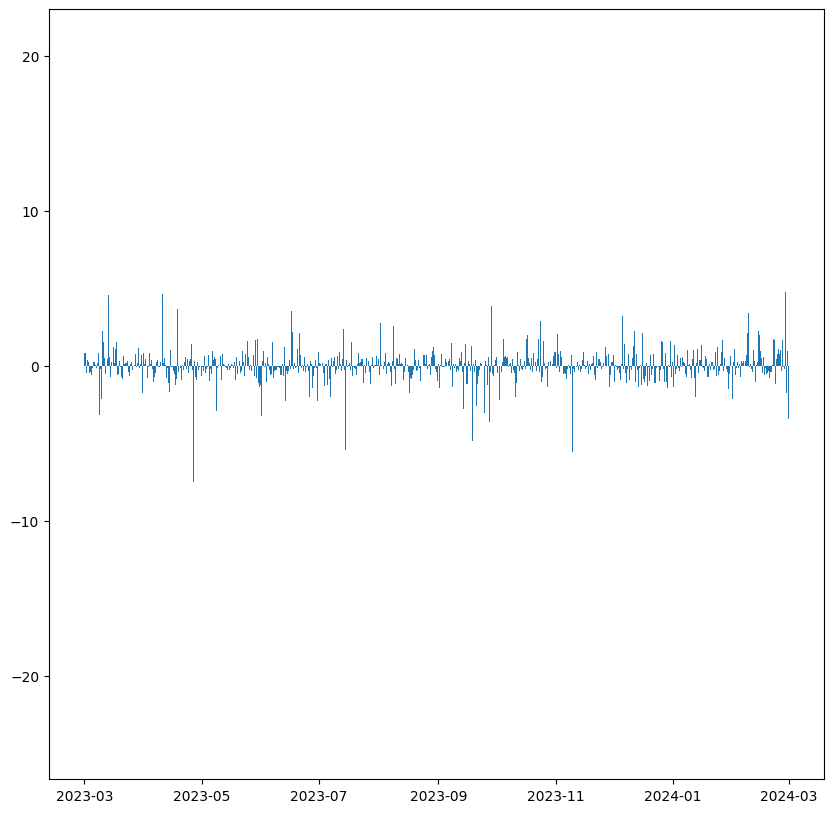

In [33]:
plot_time_series_data_overlay_major_dates(train_df, 'label')

In [6]:
mahdi_params = {
    "colsample_bylevel": 0.4778015829774066,
    "colsample_bynode": 0.362764358742407,
    "colsample_bytree": 0.7107423488010493,
    "gamma": 1.7094857725240398,
    "learning_rate": 0.02213323588455387,
    "max_depth": 20,
    "max_leaves": 12,
    "min_child_weight": 16,
    "n_estimators": 1667,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 39.352415706891264,
    "reg_lambda": 75.44843704068275,
    "subsample": 0.06566669853471274,
    "verbosity": 0
}

yuwei_params = {'max_bin': 124,
                'learning_rate': 0.05748924681991978,
                'max_depth': 31,
                'gamma': 0.46450412719997725,
                'min_child_weight': 6.647135865318027,
                'subsample': 0.7511572371061874,
                'colsample_bytree': 0.7195154778955838,
                'colsample_bylevel': 0.984665661176,
                'colsample_bynode': 0.9896896099223678,
                'reg_alpha': 0.45580746840273345, 
                'reg_lambda': 0.000135611457684535, 
                'max_cat_threshold': 1, 
                'max_cat_to_onehot': 56}

classifier_params = {
    'objective':'binary:logistic',
    'eval_metric':'auc',  
    "colsample_bylevel": 0.4778015829774066,
    "colsample_bynode": 0.362764358742407,
    "colsample_bytree": 0.7107423488010493,
    "gamma": 1.7094857725240398,
    "learning_rate": 0.02213323588455387,
    "max_depth": 20,
    "max_leaves": 12,
    "min_child_weight": 16,
    "n_estimators": 1667,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 39.352415706891264,
    "reg_lambda": 75.44843704068275,
    "subsample": 0.06566669853471274,
    "verbosity": 0
}

In [8]:
# binary_train = train_df.copy(deep=True)
# binary_train['label'] = np.tanh(binary_train[])

#1/(1 + np.exp(-binary_train['label'].values))
# binary_train['label'] = (binary_train['label'] > 0).astype(int)

In [9]:
from sklearn.metrics import accuracy_score

class TanhTransform(IFeatureTransformer):
    def transform(original_settings : DataSciencePipelineSettings):
        settings = deepcopy(original_settings)
        train_df, test_df = settings.update()
        train_df[settings.target_col_name] = np.tanh(train_df[settings.target_col_name])
        settings.combined_df = pd.concat([train_df, test_df], keys=['train', 'test'])
        return settings

scve = SafeCrossValidationExecutor(
    sklearn_model_instance=XGBoostModel(**yuwei_params), #SklearnWrapper(alpha=1),
    evaluation_metric=lambda x, y : pearsonr(x, y).statistic,#lambda x, y : accuracy_score(x, np.where(y > 0.5, 1, 0)),
    kfold_object=KFold(5, random_state=42, shuffle=True),
    train_csv_path=train_csv_path,
    test_csv_path=test_csv_path,
    target_col_name='label',
    training_features=['X758', 'X752', 'X344', 'X425', 'X757', 'X345', 'X383', 'X613',
                                                           'X759', 'X778', 'X415', 'X610', 'X751', 'X508', 'X174', 'X614',
                                                           'X427', 'X767', 'X180', 'X466'],
    pipeline_transforms=[
        # ReduceMemoryUsage.transform,
        # TanhTransform.transform,
        # RemoveEventsFromTimePeriod(list_of_major_events).transform,
        # FillInfValues.transform,
        # lambda x : RemoveOutliers.transform(x, lq=0.2, uq=0.8),
        # FillNullValues.transform,
        # StandardScaleNumerical.transform
                        ]
)
(score_tuple,
 oof_predictions,
 model_list,
 test_predictions) = scve.run(train_data=new_train_df, test_data=new_test_df)

/usr/local/lib/python3.12/site-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(
0it [00:00, ?it/s]INFO:cross_validation_log:The CV results of the current fold is 0.975127565074238
1it [00:19, 19.48s/it]INFO:cross_validation_log:The CV results of the current fold is 0.9756929323048753
2it [00:37, 18.40s/it]INFO:cross_validation_log:The CV results of the current fold is 0.9737296523200786
3it [00:54, 17.83s/it]INFO:cross_validation_log:The CV results of the current fold is 0.9744280407225423
4it [01:11, 17.60s/it]INFO:cross_validation_log:The CV results of the current fold is 0.9744979870267886
5it [01:28, 17.79s/it]

####################################################################################################
OOF prediction score :  0.9746901073880668
Mean 5-cv results : 0.9746952354897045 +- 0.0006670770063270516
####################################################################################################


In [11]:
sample_sub = pd.read_csv("../data/DRW_crypto_price_prediction/sample_submission.csv", index_col=0)
sample_sub['prediction'] = test_predictions
sample_sub.to_csv("../submissions/drw/submission_31.csv")
sample_sub.head()

,prediction
ID,
1,-0.124723
2,0.221965
3,-0.533343
4,-0.441634
5,-0.532922


In [10]:
train_df['label'] = np.abs(train_df['label'])

In [ ]:
from ktools.modelling.bayesian.variational_gp import VariationalGP


VariationalGP

In [11]:
from sklearn.metrics import root_mean_squared_error


scve = SafeCrossValidationExecutor(
    sklearn_model_instance=XGBoostModel(**mahdi_params), #SklearnWrapper(alpha=1),
    evaluation_metric=root_mean_squared_error,
    kfold_object=TimeSeriesSplit(5),#KFold(5, random_state=42, shuffle=True),
    train_csv_path=train_csv_path,
    test_csv_path=test_csv_path,
    target_col_name='label',
    training_features=["X863", "X856", "X344", "X598", "X862", "X385", "X852", "X603", "X860", "X674",
    "X415", "X345", "X137", "X855", "X174", "X302", "X178", "X532", "X168", "X612",
    "bid_qty", "ask_qty", "buy_qty", "sell_qty", "volume"],
    pipeline_transforms=[
        # ReduceMemoryUsage.transform,
        # RemoveEventsFromTimePeriod(list_of_major_events).transform,
        FillInfValues.transform,
        # lambda x : RemoveOutliers.transform(x, lq=0.2, uq=0.8),
        FillNullValues.transform,
        StandardScaleNumerical.transform
                        ]
)

(score_tuple,
 mag_oof_predictions,
 model_list,
 mag_test_predictions) = scve.run(train_data=train_df, test_data=test_df)

/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/sklearn/model_selection/_split.py:1213: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(
0it [00:00, ?it/s]

INFO:cross_validation_log:The CV results of the current fold is 0.7370205521583557
1it [00:01,  2.00s/it]INFO:cross_validation_log:The CV results of the current fold is 0.7975037097930908
2it [00:04,  2.49s/it]INFO:cross_validation_log:The CV results of the current fold is 0.7684149742126465
3it [00:08,  2.99s/it]INFO:cross_validation_log:The CV results of the current fold is 0.6767498850822449
4it [00:12,  3.36s/it]INFO:cross_validation_log:The CV results of the current fold is 0.7725720405578613
5it [00:17,  3.40s/it]

####################################################################################################
OOF prediction score :  0.8035643742475335
Mean 5-cv results : 0.7504522204399109 +- 0.04156497120857239
####################################################################################################


In [12]:
pearsonr(mag_oof_predictions * (sign_oof_predictions - 0.5), train_df['label']).statistic

0.049725249693240915

In [10]:
class SklearnWrapper(SGDRegressor):

    def __init__(
        self,
        loss="squared_error",
        *,
        penalty="l2",
        alpha=0.0001,
        l1_ratio=0.15,
        fit_intercept=True,
        max_iter=1000,
        tol=1e-3,
        shuffle=True,
        verbose=0,
        epsilon=0.1,
        random_state=129,
        learning_rate="invscaling",
        eta0=0.01,
        power_t=0.25,
        early_stopping=False,
        validation_fraction=0.1,
        n_iter_no_change=5,
        warm_start=False,
        average=False,
    ):
        super().__init__(
            loss=loss,
            penalty=penalty,
            alpha=alpha,
            l1_ratio=l1_ratio,
            fit_intercept=fit_intercept,
            max_iter=max_iter,
            tol=tol,
            shuffle=shuffle,
            verbose=verbose,
            epsilon=epsilon,
            random_state=random_state,
            learning_rate=learning_rate,
            eta0=eta0,
            power_t=power_t,
            early_stopping=early_stopping,
            validation_fraction=validation_fraction,
            n_iter_no_change=n_iter_no_change,
            warm_start=warm_start,
            average=average,
        )

    def fit(self, X, y, **kwargs):
        return super().fit(X, y)
    

scve = SafeCrossValidationExecutor(
    sklearn_model_instance=XGBoostModel(**mahdi_params), #SklearnWrapper(alpha=1),
    evaluation_metric=lambda x, y : pearsonr(x, y).statistic,
    kfold_object=TimeSeriesSplit(5),
    train_csv_path=train_csv_path,
    test_csv_path=test_csv_path,
    target_col_name='label',
    training_features=["X863", "X856", "X344", "X598", "X862", "X385", "X852", "X603", "X860", "X674",
    "X415", "X345", "X137", "X855", "X174", "X302", "X178", "X532", "X168", "X612",
    "bid_qty", "ask_qty", "buy_qty", "sell_qty", "volume"],
    pipeline_transforms=[
        # ReduceMemoryUsage.transform,
        RemoveEventsFromTimePeriod(list_of_major_events).transform,
        FillInfValues.transform,
        # lambda x : RemoveOutliers.transform(x, lq=0.2, uq=0.8),
        FillNullValues.transform,
        StandardScaleNumerical.transform
                        ]
)

In [11]:
(score_tuple,
 oof_predictions,
 model_list,
 test_predictions) = scve.run(train_data=train_df, test_data=test_df)

/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/sklearn/model_selection/_split.py:1213: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(
0it [00:00, ?it/s]INFO:cross_validation_log:The CV results of the current fold is 0.10367283225059509
1it [00:02,  2.91s/it]INFO:cross_validation_log:The CV results of the current fold is 0.0839976966381073
2it [00:07,  3.80s/it]INFO:cross_validation_log:The CV results of the current fold is 0.045926980674266815
3it [00:12,  4.08s/it]

####################################################################################################
OOF prediction score :  0.06885551907582667
Mean 3-cv results : 0.0778658390045166 +- 0.02397006005048752
####################################################################################################


In [10]:
sample_sub = pd.read_csv("/Users/yuwei-1/Documents/projects/Kaggle-tools/data/DRW_crypto_price_prediction/sample_submission.csv", index_col=0)
sample_sub['prediction'] = sign_test_predictions#mag_test_predictions * (sign_test_predictions - 0.5)#test_predictions
sample_sub.to_csv("/Users/yuwei-1/Documents/projects/Kaggle-tools/submissions/drw/submission_25.csv")

In [11]:
sample_sub

,prediction
ID,
1,-0.002162
2,-0.020968
3,0.035647
4,-0.003229
5,0.058872
...,...
538146,-0.031419
538147,-0.027702
538148,0.049828
